In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
train_path = "/kaggle/input/store-sales-time-series-forecasting/train.csv"
test_path = "/kaggle/input/store-sales-time-series-forecasting/test.csv"
sample_path = "/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv"
oil_path = "/kaggle/input/store-sales-time-series-forecasting/oil.csv"
holidays_path = "/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv"
stores_path = "/kaggle/input/store-sales-time-series-forecasting/stores.csv"
transactions_path = "/kaggle/input/store-sales-time-series-forecasting/transactions.csv"

In [3]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sample = pd.read_csv(sample_path)
oil = pd.read_csv(oil_path)
holidays = pd.read_csv(holidays_path)
stores = pd.read_csv(stores_path)
transactions = pd.read_csv(transactions_path)

In [4]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [5]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [6]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [7]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [8]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [9]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [10]:
train.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [11]:
test.tail()

,id,date,store_nbr,family,onpromotion
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9
28511,3029399,2017-08-31,9,SEAFOOD,0


We can see that the training data contains information from 1st January 2013 to 15th August 2017, and the test data goes from 16th August 2017 to 31st August 2017, i.e. we want to predict sales for the following 15 days. Let's do some EDA to get a better grasp of the data... 

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='date', ylabel='sales'>

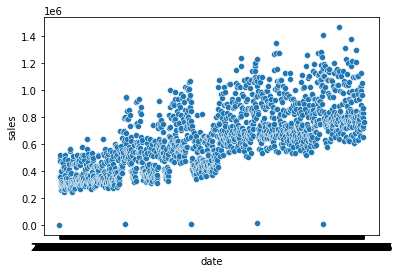

In [13]:
total_sales_per_day = train[["date", "sales"]].groupby("date").sum().reset_index()

sns.scatterplot(x=total_sales_per_day["date"], y=total_sales_per_day["sales"])

We notice that there are 5 dates which seem to have zero sales, and they appear to be equally spaced. Given that the data spans about 5 years, this is probably due to a public holiday. We also see that there is overall upward trend in the total number of sales. It also seems like there are annual bumps in sales, perhaps around the start of the year, or the end of the previous year, but it's not completely clear from this plot alone. 

In [14]:
total_sales_per_day_family = train[["date", "family", "sales"]].groupby(["date", "family"]).sum().reset_index()
total_sales_per_day_family.head()

,date,family,sales
0,2013-01-01,AUTOMOTIVE,0.0
1,2013-01-01,BABY CARE,0.0
2,2013-01-01,BEAUTY,2.0
3,2013-01-01,BEVERAGES,810.0
4,2013-01-01,BOOKS,0.0


<AxesSubplot:xlabel='date', ylabel='sales'>

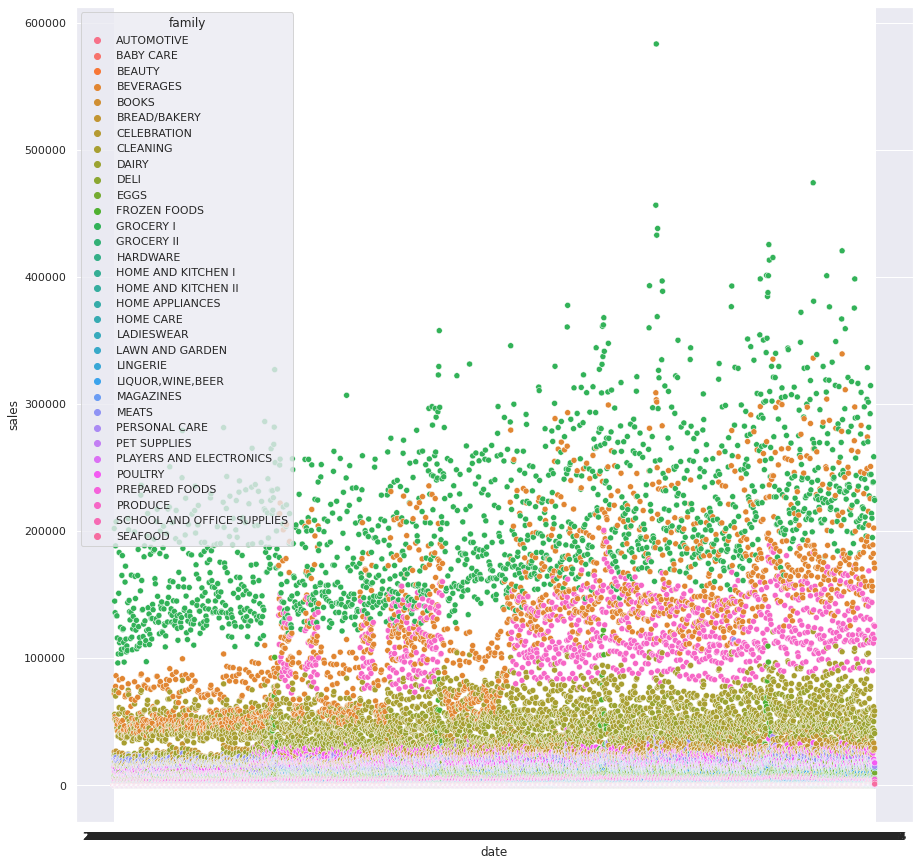

In [15]:
total_sales_per_day_family = train[["date", "family", "sales"]].groupby(["date", "family"]).sum().reset_index()

sns.set(rc = {'figure.figsize':(15,15)})

total_sales_family_plt = sns.scatterplot(x=total_sales_per_day_family["date"], y=total_sales_per_day_family["sales"], hue=total_sales_per_day_family["family"])
total_sales_family_plt

Since there quite a lot of families, much of the data blurs together in the above plot. However, there is still useful information we can derive from this. We can clearly see that grocery sales are the highest compares to all other families, and it also appears as though the upwards trend is steepest for groceries as well. We also see that all of the most popular product families are food-related: groceries, beverages, frozen food, deli, eggs, poultry, etc. This tells us that these are the families that we should focus on the most moving forward, as they dominate the sales. This is as expected, since these are the most essential items and are used quickly (e.g. most families will do food shops at least once a week). 

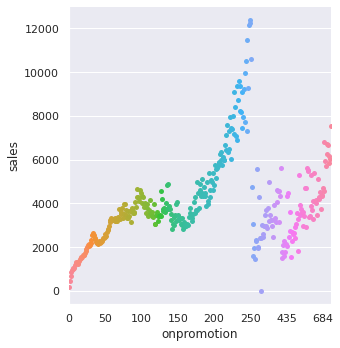

In [16]:
#Let's look at the onpromotion column and see if the number of items on promotion affects the sales noticeably... 

total_sales_per_promo = train[["sales", "onpromotion"]].groupby("onpromotion").mean().reset_index()

sales_per_promo_plt = sns.catplot(data=total_sales_per_promo, x="onpromotion", y="sales")

for ind, label in enumerate(sales_per_promo_plt.axes[0][0].get_xticklabels()):
    if ind % 50 == 0:  #Only label the first date of every year to keep x 
        label.set_visible(True)
    else:
        label.set_visible(False)

sales_per_promo_plt

Note that we have plotted the mean sales here, not the total sales. We see that, up until around 250 items on promotion, there is generally an upwards trend (though it looks more like a cubic polynomial), but then after that the sales fall dramatically. Perhaps there is some sort of trade-off here? More items will be put on sale when sales are low, but sales will in turn attract more customers. It may be that these days corresponding to very high numbers of promotional items were during times when sales were particularly low. Is this related to the earthquake on April 16th 2016? Let's take a look at the frequency of each onpromotion value...

In [17]:
for (index, value) in zip(train["onpromotion"].value_counts().index, train["onpromotion"].value_counts().values) :
    if index>250:
        print(index, value)

276 4
304 4
251 3
252 3
630 2
489 2
261 2
282 2
716 2
264 2
258 2
293 2
639 2
269 2
302 2
435 2
259 1
512 1
275 1
496 1
678 1
254 1
253 1
543 1
719 1
286 1
297 1
485 1
722 1
294 1
473 1
290 1
424 1
629 1
718 1
420 1
677 1
464 1
469 1
741 1
281 1
283 1
326 1
519 1
591 1
263 1
467 1
697 1
330 1
407 1
486 1
411 1
539 1
391 1
289 1
655 1
609 1
446 1
322 1
710 1
511 1
628 1
536 1
702 1
726 1
279 1
333 1
444 1
646 1
644 1
383 1
600 1
306 1
672 1
470 1
474 1
624 1
317 1
507 1
626 1
332 1
510 1
668 1
299 1
300 1
520 1
717 1
342 1
720 1
479 1
285 1
320 1
528 1
633 1
476 1
312 1
441 1
657 1
255 1
684 1
547 1
307 1
277 1
481 1
664 1
551 1
313 1
452 1
642 1
305 1
425 1


From this, we can see that there were very few days with more than 250 discounts overall, suggesting that these days were outliers in some way. Perhaps they corresponded to some sort of holiday, or the eartquake? Let's look at the dates for these cases: 

In [18]:
train_large_promotion = train[train["onpromotion"]>250]

In [19]:
train_large_promotion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133 entries, 2159589 to 2964402
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           133 non-null    int64  
 1   date         133 non-null    object 
 2   store_nbr    133 non-null    int64  
 3   family       133 non-null    object 
 4   sales        133 non-null    float64
 5   onpromotion  133 non-null    int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 7.3+ KB


In [20]:
train_large_promotion.head()

,id,date,store_nbr,family,sales,onpromotion
2159589,2159589,2016-04-29,53,BEVERAGES,2948.0,289
2159598,2159598,2016-04-29,53,GROCERY I,3420.0,609
2159631,2159631,2016-04-29,54,GROCERY I,2225.0,261
2161371,2161371,2016-04-30,53,BEVERAGES,4042.0,322
2161375,2161375,2016-04-30,53,CLEANING,2320.0,276


In [21]:
train_large_promotion.tail()

,id,date,store_nbr,family,sales,onpromotion
2915019,2915019,2017-06-28,49,PRODUCE,11089.586,252
2916213,2916213,2017-06-29,33,BEVERAGES,5584.000,263
2916222,2916222,2017-06-29,33,GROCERY I,5479.000,591
2963709,2963709,2017-07-26,16,GROCERY I,2984.000,519
2964402,2964402,2017-07-26,35,GROCERY I,2123.000,425


In [22]:
train_large_promotion["date"].value_counts()

2016-05-20    4
2016-05-21    4
2016-05-19    4
2016-05-22    4
2016-05-17    4
2016-05-23    4
2016-05-15    4
2016-05-14    4
2016-05-13    4
2016-05-25    4
2016-04-30    4
2016-05-27    4
2016-05-28    4
2016-05-07    4
2016-05-29    4
2016-05-30    4
2016-05-04    4
2016-05-31    4
2017-05-24    4
2016-05-01    4
2016-05-24    3
2016-05-26    3
2016-04-29    3
2016-05-02    3
2016-05-12    3
2016-05-11    3
2016-05-10    3
2016-05-09    3
2016-05-08    3
2016-05-06    3
2016-05-05    3
2016-05-03    3
2016-05-16    3
2016-05-18    2
2017-06-29    2
2017-06-28    2
2017-07-26    2
2017-03-30    1
2017-04-26    1
2017-03-29    1
2017-02-08    1
2017-01-25    1
2016-12-28    1
Name: date, dtype: int64

As we can see, the majority of these dates are in May and April 2016, which is around the time of the earthquake, so it seems our intuition was correct in thinking that this played a role. We also see that there are some dates in 2017 present, though most of these seem to be isolated. We could analyse these further, but it is probably more instructive to continue visualising the data. Let's have a look at how the sales vary across different time periods...

In [23]:
#Let's extract the year, month, day and day of the week separately so that we can make use of them: 

train["year"] = pd.to_datetime(train["date"]).dt.year
train["month"] = pd.to_datetime(train["date"]).dt.month
train["day"] = pd.to_datetime(train["date"]).dt.day
train["day_of_week"] = pd.to_datetime(train["date"]).dt.day_name()

In [24]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,Tuesday
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,Tuesday
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,Tuesday
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,Tuesday
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,Tuesday


<AxesSubplot:xlabel='month', ylabel='sales'>

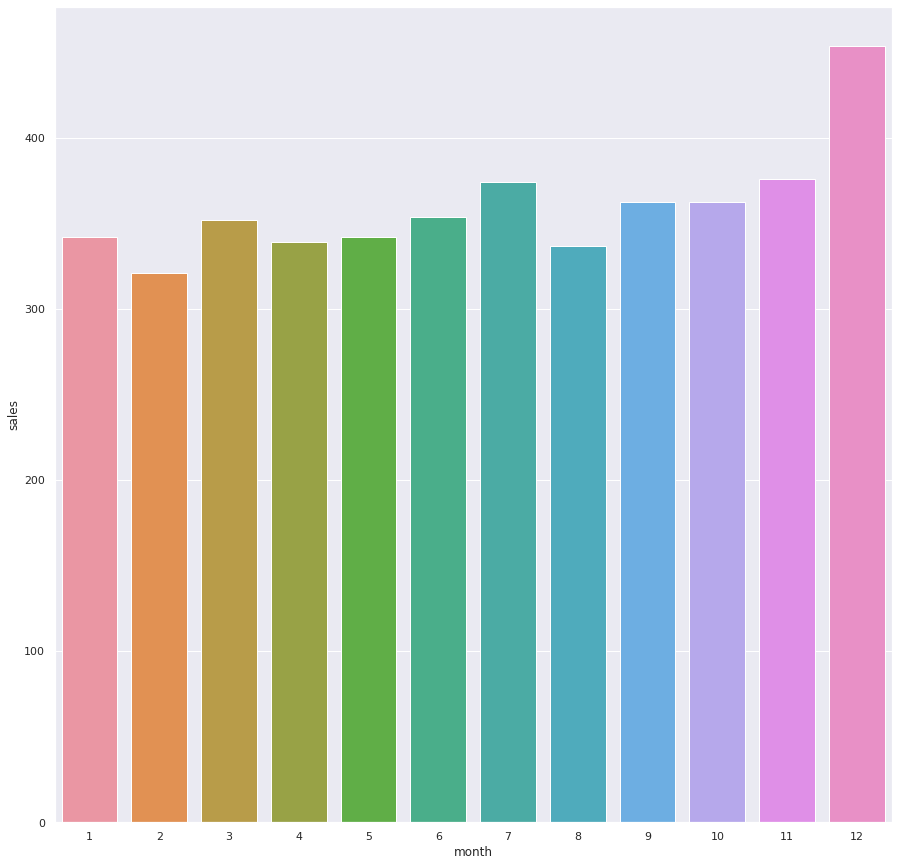

In [25]:
mean_sales_month = train.groupby(["month"])["sales"].mean().reset_index()

mean_sales_month_plt = sns.barplot(x=mean_sales_month["month"], y=mean_sales_month["sales"])
mean_sales_month_plt

As expected, there is not much variation except for a spike in December, most likely due to Christmas. This ties in with our earlier observation that most of the sales were for food items, since these items will be needed all year round and so we would expect their sale numbers to remain fairly consistent. 

<AxesSubplot:xlabel='day', ylabel='sales'>

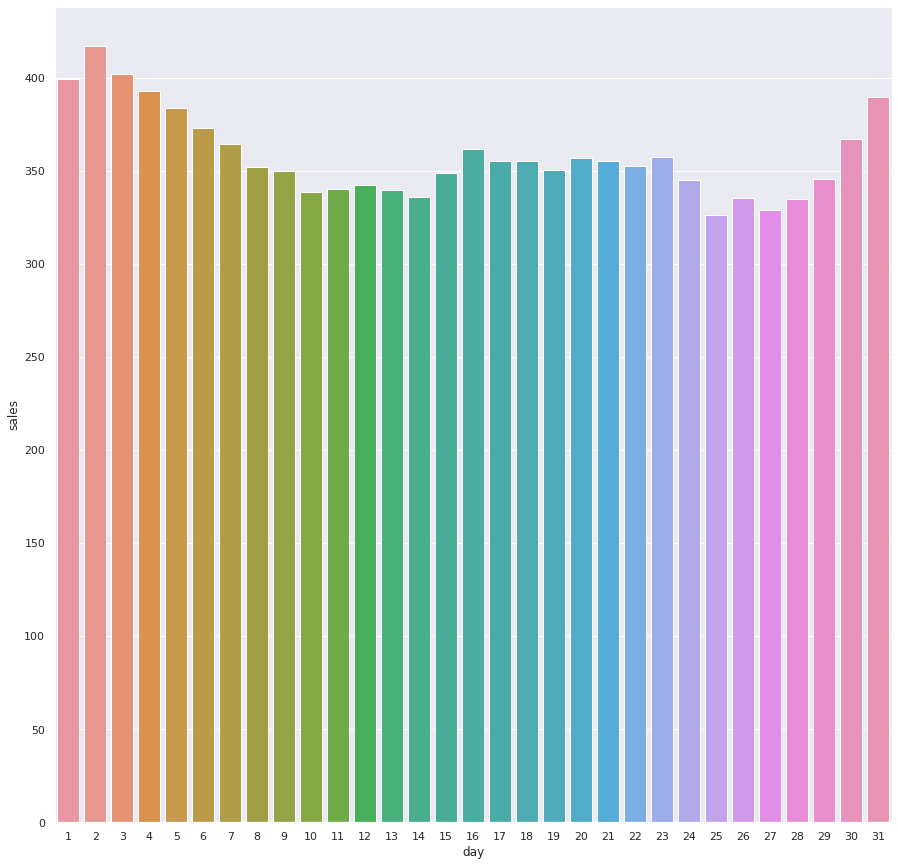

In [26]:
mean_sales_day = train.groupby(["day"])["sales"].mean().reset_index()

mean_sales_month_day_plt = sns.barplot(x=mean_sales_day["day"], y=mean_sales_day["sales"])
mean_sales_month_day_plt

There seem to be spikes at the beginning and end of the month, which may be due to start/end of month sales. Let's look at this data for each month to see if that makes thing any clearer. To do this, we will use seaborn's FacetGrid class: 

In [27]:
mean_sales_day_month = train.groupby(["month","day"])["sales"].mean().reset_index()

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


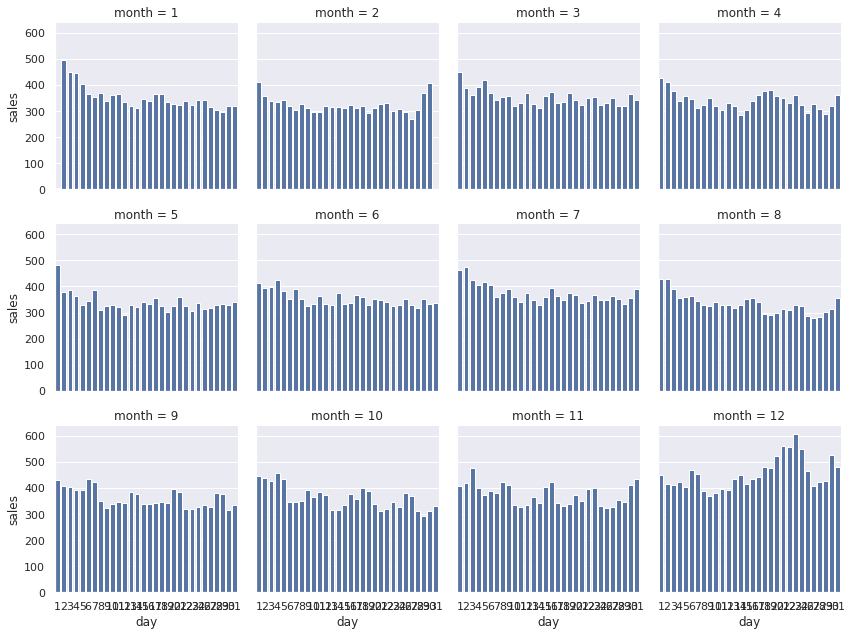

In [28]:
mean_sales_day_months_plt = sns.FacetGrid(mean_sales_day_month, col="month", margin_titles=True, col_wrap=4)
mean_sales_day_months_plt.map(sns.barplot, "day", "sales")

From the above, it seems like there is indeed a consistent spike at the beginning of every month, though the spikes at the end are much less pronounced. We see that Christmas completely changes the sale trends in December, with a large spike towards the end of the month. This probably contributed to the spike we saw in the overall monthly day-by-day mean sales we saw earlier. 

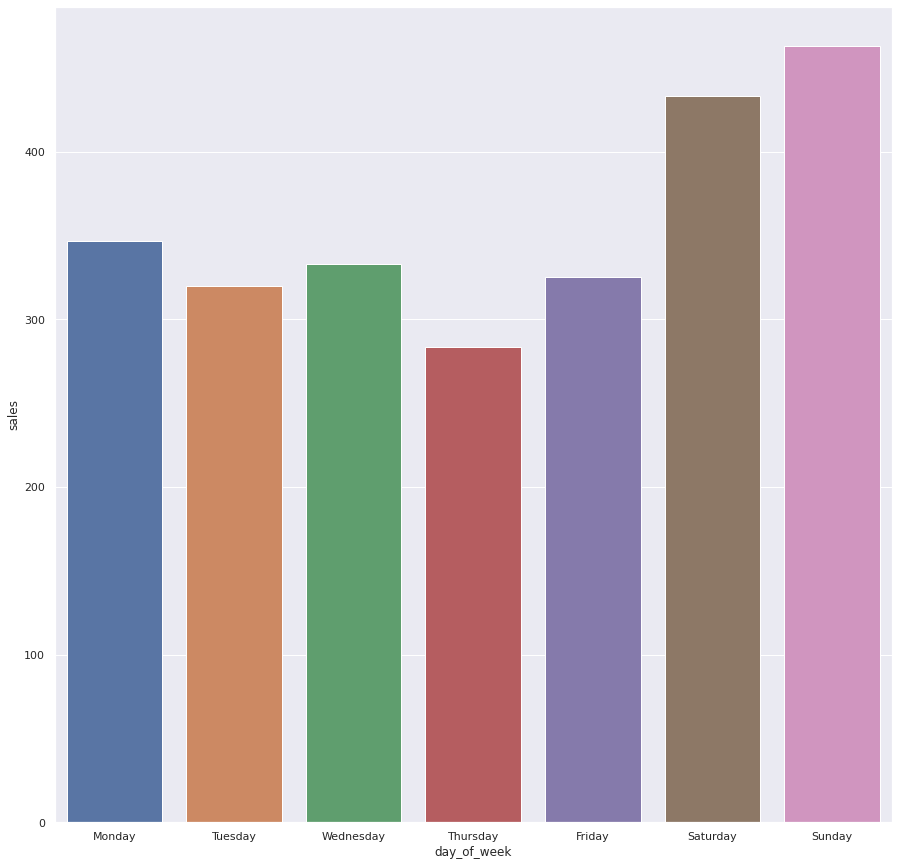

In [29]:
mean_sales_week = train.groupby(["day_of_week"])["sales"].mean()

week_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

mean_sales_week = mean_sales_week.reindex(week_days, axis=0).reset_index()

mean_sales_week_plt = sns.barplot(x=mean_sales_week["day_of_week"], y=mean_sales_week["sales"])

As expected, there is a spike in sales on the weekend, and not much variation during the working week. 

In [30]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [31]:
train_oil = pd.merge(train, oil, on="date", how="inner")

In [32]:
train_oil.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,Tuesday,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,Tuesday,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,Tuesday,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,Tuesday,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,Tuesday,NaN


In [33]:
#Let's see how sales varied with oil prices: 

sales_oil = train_oil[["date","sales","dcoilwtico"]].groupby(["date"]).mean().reset_index()

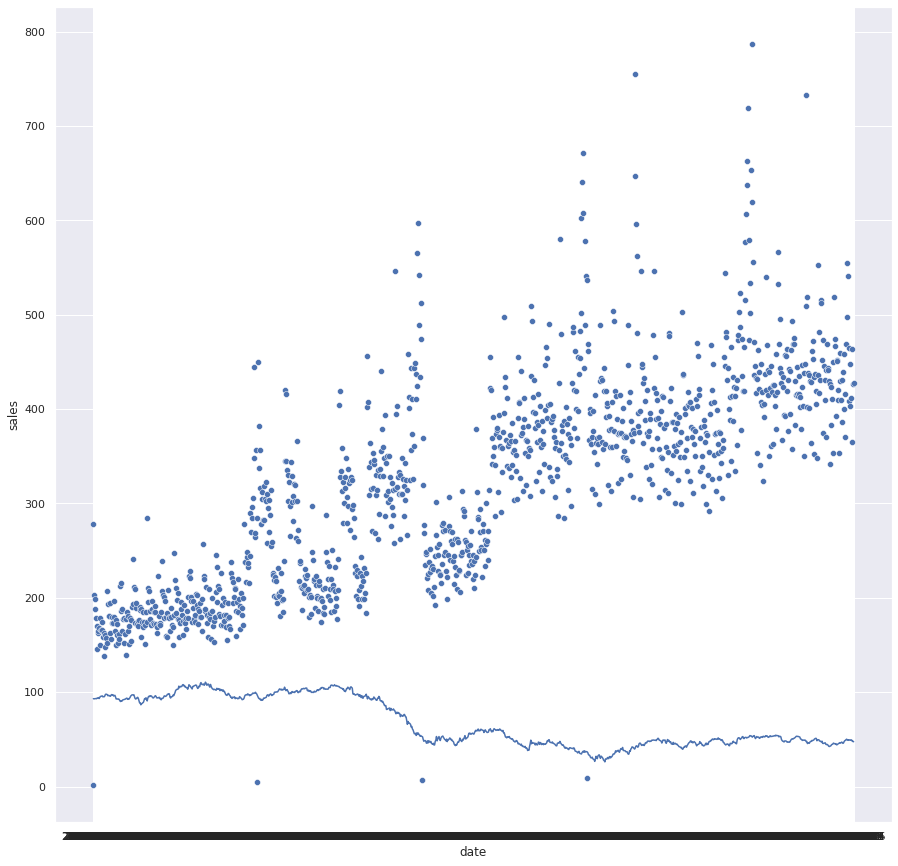

In [34]:
mean_sales_oil_plt, ax = plt.subplots()
sns.scatterplot(x=sales_oil["date"], y=sales_oil["sales"])
sns.lineplot(x=sales_oil["date"], y=sales_oil["dcoilwtico"])
plt.show()

We see that there was a sharp dip in oil prices at one point, though it's unclear if it had much effect on sales. When we come to feature engineering, we will be able to look at this more quantitatively. 

In [35]:
train_holidays = pd.merge(train, holidays, on="date", how="inner")

In [36]:
train_holidays.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,type,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,Tuesday,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,Tuesday,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,Tuesday,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,Tuesday,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,Tuesday,Holiday,National,Ecuador,Primer dia del ano,False


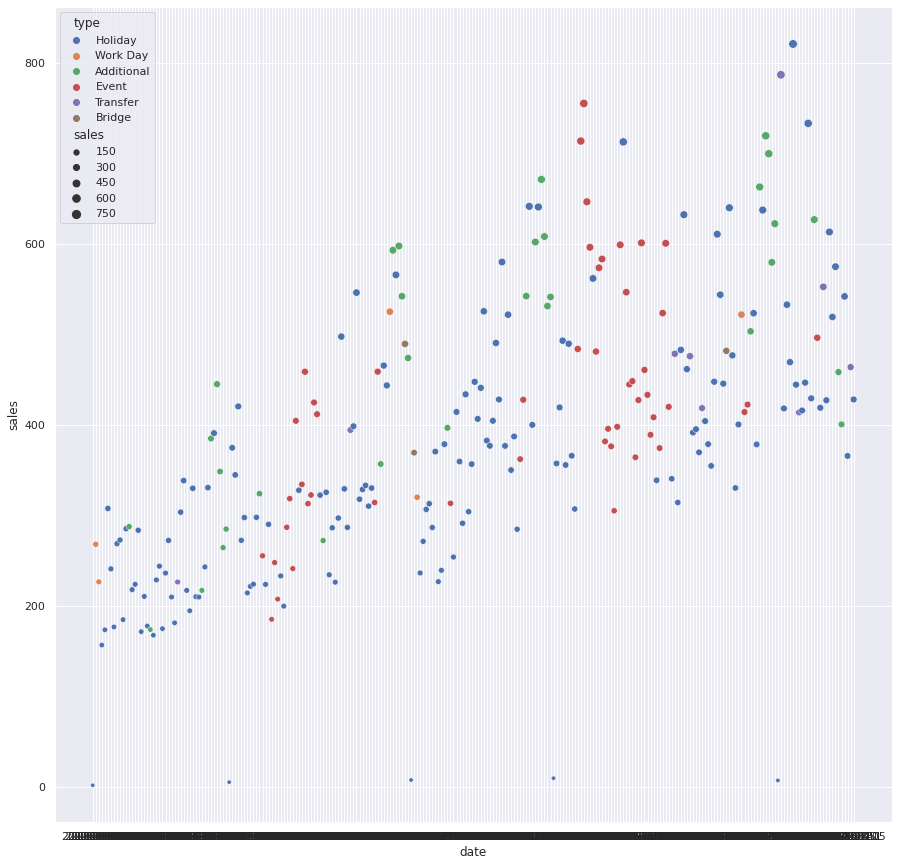

In [37]:
sales_holidays = train_holidays[["date","sales","type"]].groupby(["date","type"]).mean().reset_index()
sales_holidays_plt = sns.scatterplot(x=sales_holidays["date"], y=sales_holidays["sales"], size=sales_holidays["sales"], hue=sales_holidays["type"])

In [38]:
train_store = pd.merge(train, stores, on="store_nbr", how="inner")

In [39]:
train_store.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,Tuesday,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,Tuesday,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,Tuesday,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,Tuesday,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,Tuesday,Quito,Pichincha,D,13


[Text(0, 0, 'Ambato'),
 Text(1, 0, 'Babahoyo'),
 Text(2, 0, 'Cayambe'),
 Text(3, 0, 'Cuenca'),
 Text(4, 0, 'Daule'),
 Text(5, 0, 'El Carmen'),
 Text(6, 0, 'Esmeraldas'),
 Text(7, 0, 'Guaranda'),
 Text(8, 0, 'Guayaquil'),
 Text(9, 0, 'Ibarra'),
 Text(10, 0, 'Latacunga'),
 Text(11, 0, 'Libertad'),
 Text(12, 0, 'Loja'),
 Text(13, 0, 'Machala'),
 Text(14, 0, 'Manta'),
 Text(15, 0, 'Playas'),
 Text(16, 0, 'Puyo'),
 Text(17, 0, 'Quevedo'),
 Text(18, 0, 'Quito'),
 Text(19, 0, 'Riobamba'),
 Text(20, 0, 'Salinas'),
 Text(21, 0, 'Santo Domingo')]

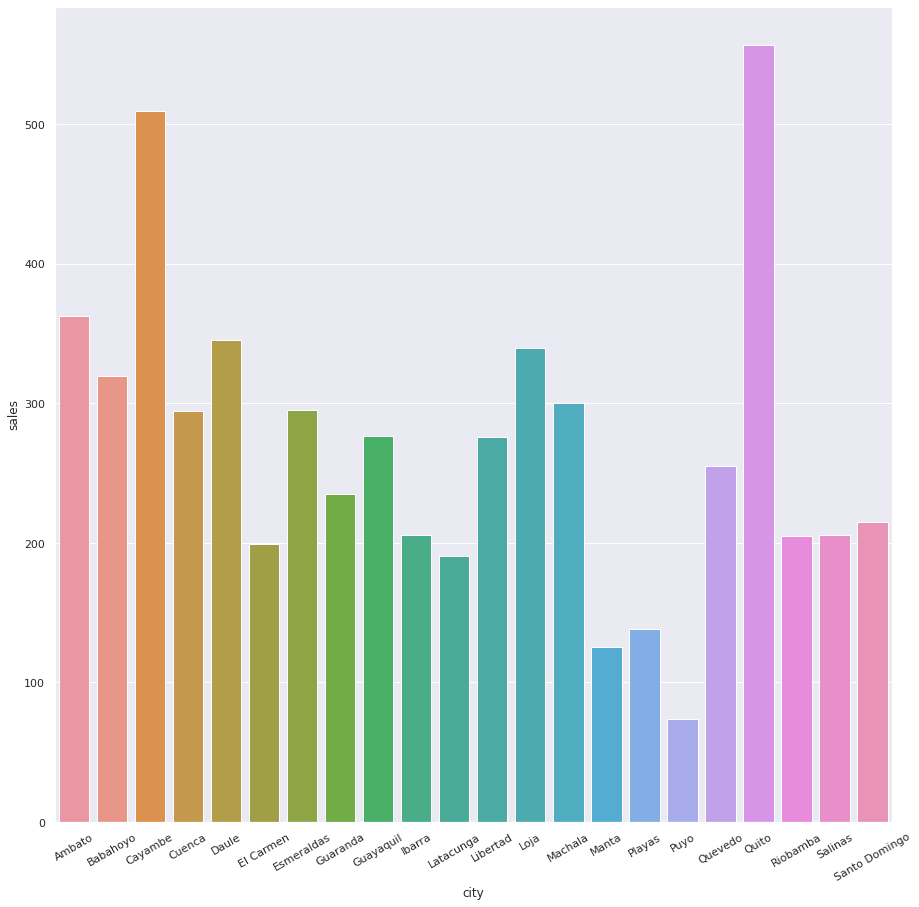

In [40]:
sales_city = train_store[["sales","city"]].groupby(["city"])["sales"].mean().reset_index()
sales_city_plt = sns.barplot(x=sales_city["city"], y=sales_city["sales"])
sales_city_plt.set_xticklabels(sales_city_plt.get_xticklabels(),rotation = 30)

[Text(0, 0, 'Azuay'),
 Text(1, 0, 'Bolivar'),
 Text(2, 0, 'Chimborazo'),
 Text(3, 0, 'Cotopaxi'),
 Text(4, 0, 'El Oro'),
 Text(5, 0, 'Esmeraldas'),
 Text(6, 0, 'Guayas'),
 Text(7, 0, 'Imbabura'),
 Text(8, 0, 'Loja'),
 Text(9, 0, 'Los Rios'),
 Text(10, 0, 'Manabi'),
 Text(11, 0, 'Pastaza'),
 Text(12, 0, 'Pichincha'),
 Text(13, 0, 'Santa Elena'),
 Text(14, 0, 'Santo Domingo de los Tsachilas'),
 Text(15, 0, 'Tungurahua')]

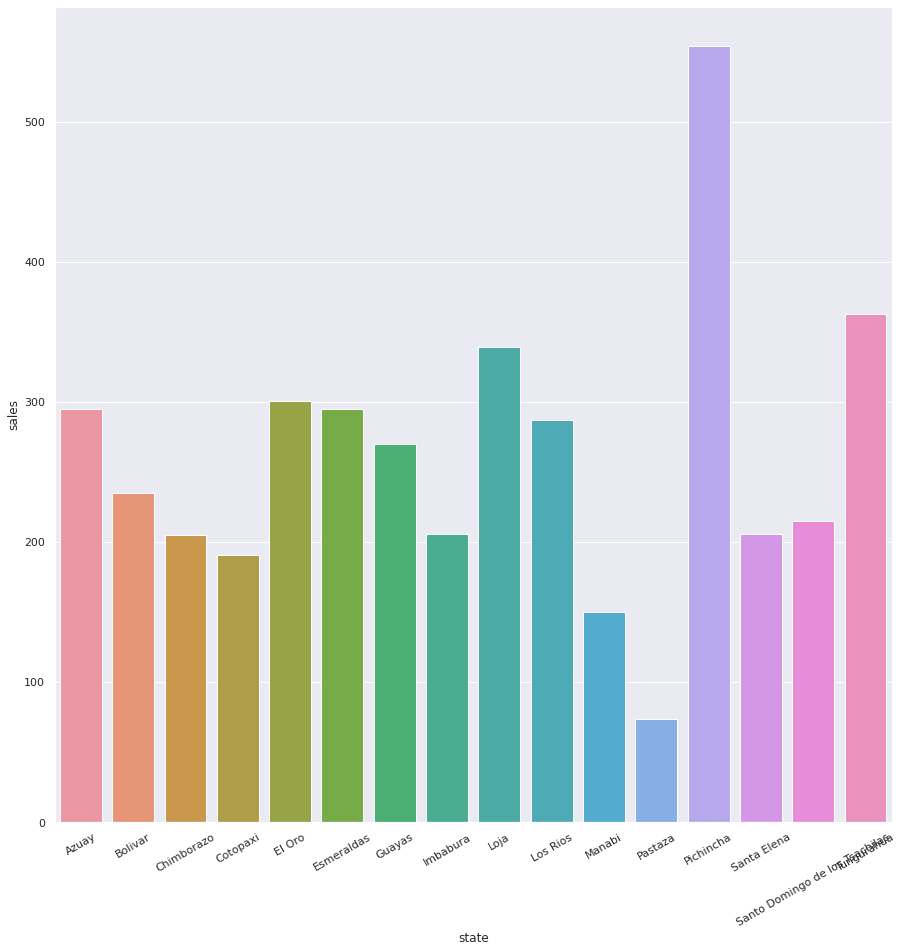

In [41]:
sales_state = train_store[["sales","state"]].groupby(["state"])["sales"].mean().reset_index()
sales_state_plt = sns.barplot(x=sales_state["state"], y=sales_state["sales"])
sales_state_plt.set_xticklabels(sales_state_plt.get_xticklabels(),rotation = 30)

[Text(0, 0, '1'),
 Text(1, 0, '2'),
 Text(2, 0, '3'),
 Text(3, 0, '4'),
 Text(4, 0, '5'),
 Text(5, 0, '6'),
 Text(6, 0, '7'),
 Text(7, 0, '8'),
 Text(8, 0, '9'),
 Text(9, 0, '10'),
 Text(10, 0, '11'),
 Text(11, 0, '12'),
 Text(12, 0, '13'),
 Text(13, 0, '14'),
 Text(14, 0, '15'),
 Text(15, 0, '16'),
 Text(16, 0, '17')]

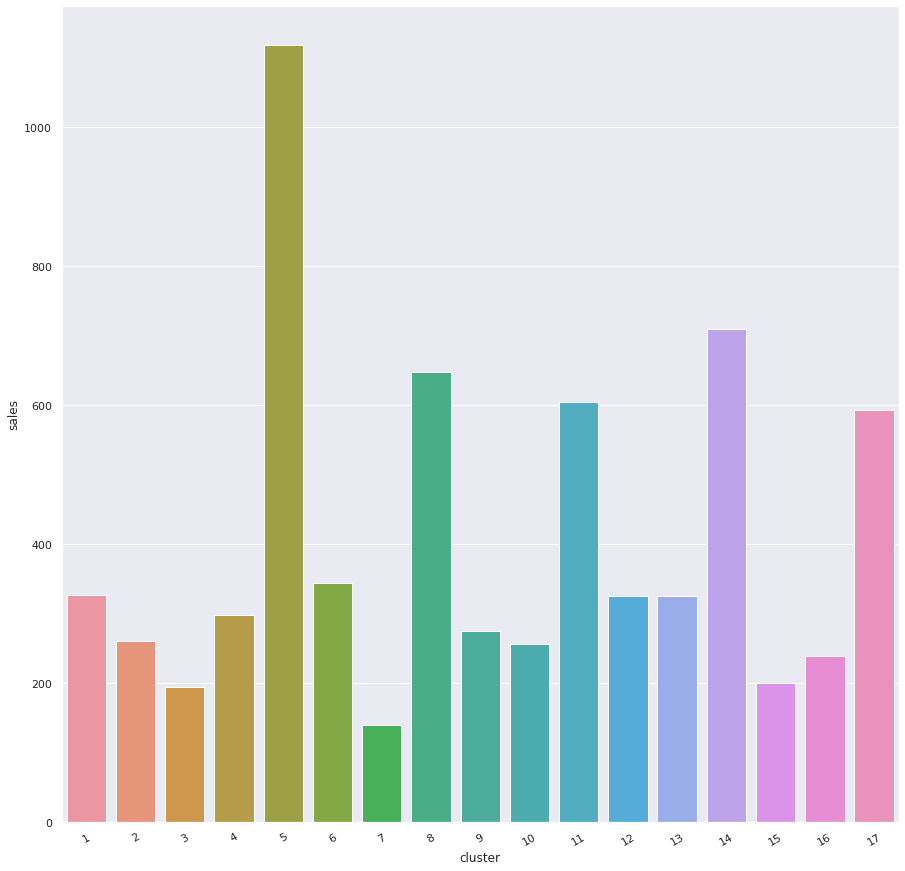

In [42]:
sales_cluster = train_store[["sales","cluster"]].groupby(["cluster"])["sales"].mean().reset_index()
sales_cluster_plt = sns.barplot(x=sales_cluster["cluster"], y=sales_cluster["sales"])
sales_cluster_plt.set_xticklabels(sales_cluster_plt.get_xticklabels(),rotation = 30)

[Text(0, 0, 'A'),
 Text(1, 0, 'B'),
 Text(2, 0, 'C'),
 Text(3, 0, 'D'),
 Text(4, 0, 'E')]

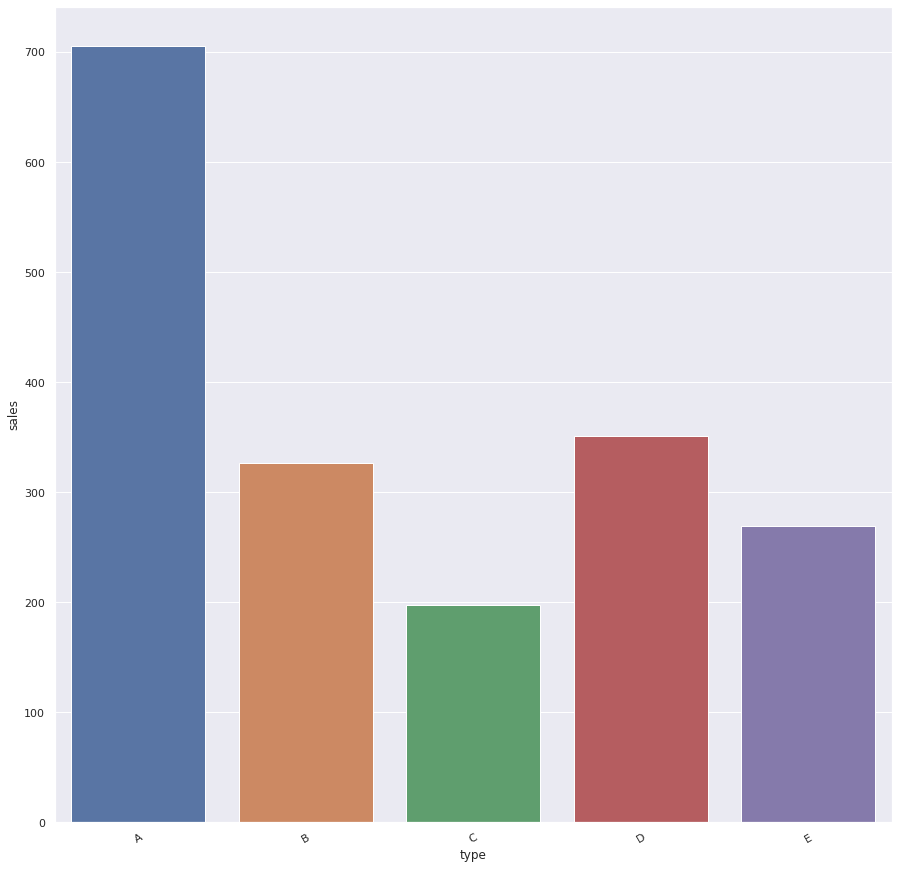

In [43]:
sales_type = train_store[["sales","type"]].groupby(["type"])["sales"].mean().reset_index()
sales_type_plt = sns.barplot(x=sales_type["type"], y=sales_type["sales"])
sales_type_plt.set_xticklabels(sales_type_plt.get_xticklabels(),rotation = 30)

We see that there are large variations in sales between different locations, whether that be by city, state, cluster or type. These should play an important role in the model building. Let's end our EDA by looking at the transactions data to see how the sales varied across stores...

In [44]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


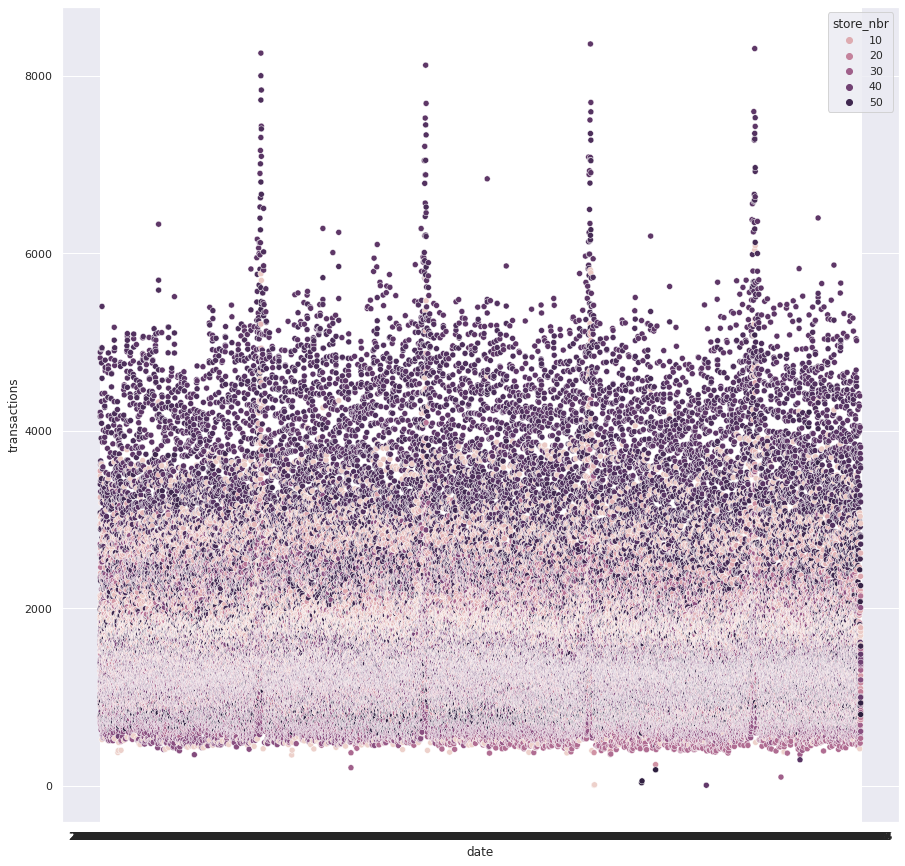

In [45]:
transactions_plt = sns.scatterplot(x=transactions["date"], y=transactions["transactions"], hue=transactions["store_nbr"])

It seems like there is a clear trend of specific stores having higher sale numbers. We consistently see the same stores with the highest sale numbers. This is as we would expect, since most stores will have fairly consistent sale trends. The stores with the highest sales are most likely in locations with the highest sales. The large variation in store sales is in keeping with the large variation in sales between different locations that we saw above. 

In [46]:
transactions_store = transactions[["store_nbr","transactions"]].groupby(["store_nbr"]).mean().reset_index()

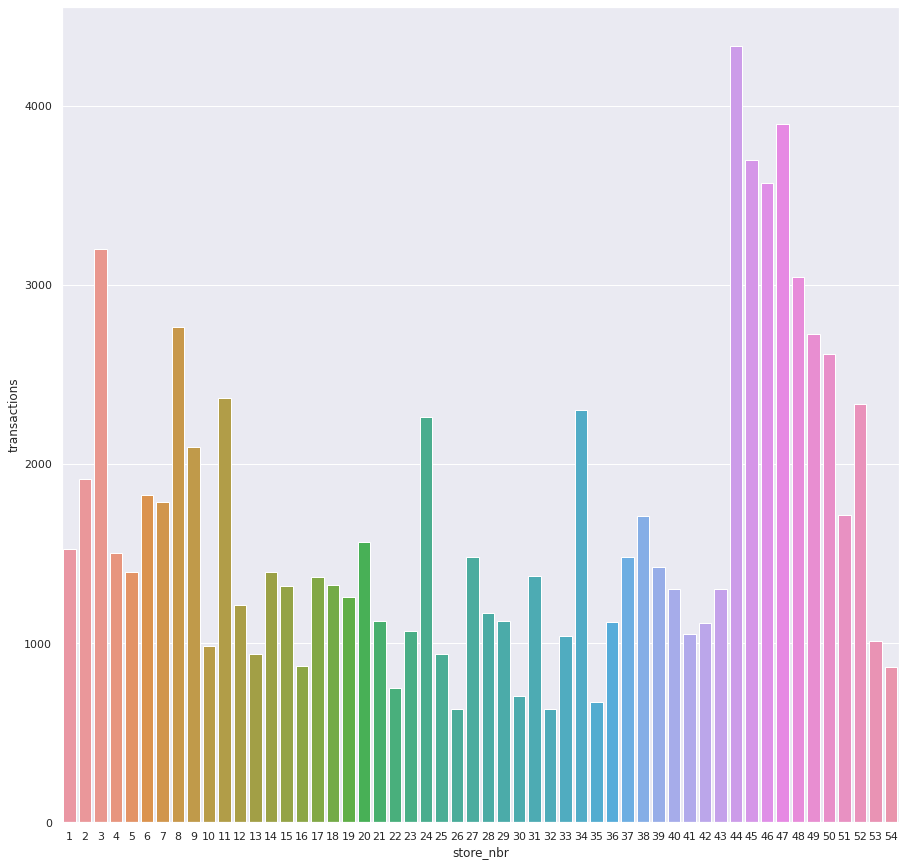

In [47]:
transactions_store_plt = sns.barplot(x=transactions_store["store_nbr"], y=transactions_store["transactions"])

In [48]:
transactions.tail()

,date,store_nbr,transactions
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
83487,2017-08-15,54,802


We only have data up to 15th August 2017, so we can't use this for predictions.

We now turn to the feature engineering, where we'll try and identify the features which capture any sort of trend, seasonal or cycle behaviour. 

In [49]:
#Recall that we have a total of 5 datasets that we could use: train, oil, store, holidays and transactions.

In [50]:
from learntools.time_series.style import * 
from learntools.time_series.utils import plot_periodogram, seasonal_plot
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf
from pathlib import Path
from warnings import simplefilter

simplefilter("ignore")


In [51]:
#Let's redefine the data sets in case we made any changes above...

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sample = pd.read_csv(sample_path)
oil = pd.read_csv(oil_path)
holidays = pd.read_csv(holidays_path)
stores = pd.read_csv(stores_path)
transactions = pd.read_csv(transactions_path)


In [52]:
# creating a combined dataset with both test and train rows.
n_train = train.shape[0]
n_test = test.shape[0]
full = pd.concat([train, test], axis = 0)

In [53]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [54]:
train.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [55]:
"""
Let's create the lag features. However, we must be careful how we create these. Note that we are making predictions
based on a particular store a particular family of products, so our lag features must have the same store and product 
family as the original data in a given row. Therefore, we need to see how many entries there are per day so that we can 
align the lag features appropriately. 
"""

#train = train.reset_index()
#train = train.set_index(["date", "store_nbr", "family"])
#print(len(train.loc["2013-01-01"]))
#train = train.reset_index().set_index("date")

len(train[train["date"]=="2013-01-01"])

1782

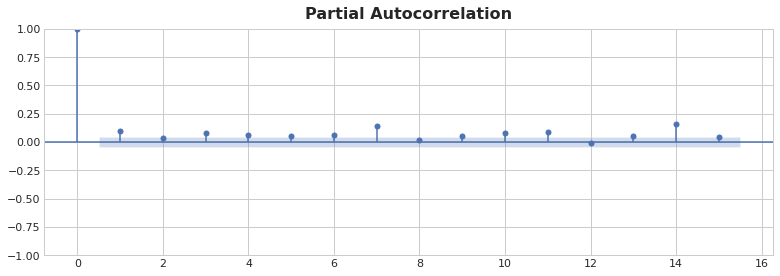

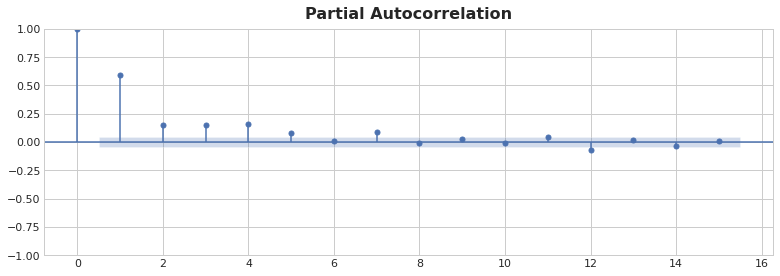

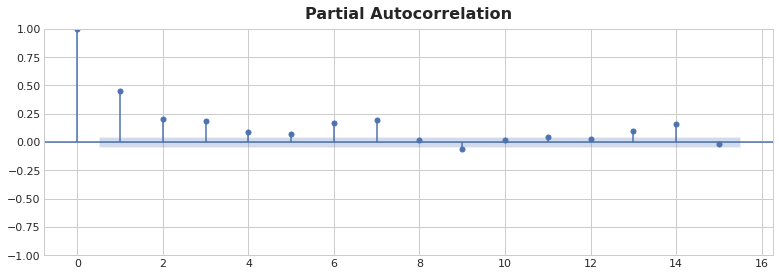

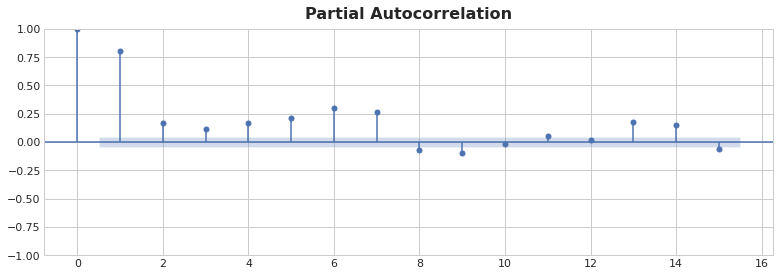

In [56]:
"""
There are 1782 entries per day,so we will need to shift in multiples of 1782 in our lag features. First, let's look at
the autocorrelation of a few store-family combinations to get an idea of how many lag features we might want...
"""

families = train["family"].unique()
stores = train["store_nbr"].unique()

#Let's take a look at a few examples:

num_examples = 4

for i in range(0, num_examples):
    train_family_store = train[(train["family"]==families[i]) & (train["store_nbr"]==stores[i])]
    pacf = plot_pacf(train_family_store["sales"], lags = 15)


Seems like around 10 lag features is a good amount.

In [57]:
for i in range(1, 11):
    full["sales_lag" + str(i)] = full["sales"].shift(1782 * i)

full["date"] = pd.to_datetime(full["date"])
full = full.set_index("date")

full.head()

,id,store_nbr,family,sales,onpromotion,sales_lag1,sales_lag2,sales_lag3,sales_lag4,sales_lag5,sales_lag6,sales_lag7,sales_lag8,sales_lag9,sales_lag10
date,,,,,,,,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,1,BABY CARE,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,2,1,BEAUTY,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,3,1,BEVERAGES,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,4,1,BOOKS,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
#Let's extract the features from the dates: 

full["year"] = pd.to_datetime(full.index).year
full["month"] = pd.to_datetime(full.index).month
full["week"] = pd.to_datetime(full.index).week
full["day"] = pd.to_datetime(full.index).day
full["dayofyear"] = pd.to_datetime(full.index).dayofyear
full["dayofweek"] = pd.to_datetime(full.index).dayofweek

In [59]:
full.head()

,id,store_nbr,family,sales,onpromotion,sales_lag1,sales_lag2,sales_lag3,sales_lag4,sales_lag5,...,sales_lag7,sales_lag8,sales_lag9,sales_lag10,year,month,week,day,dayofyear,dayofweek
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2013,1,1,1,1,1
2013-01-01,1,1,BABY CARE,0.0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2013,1,1,1,1,1
2013-01-01,2,1,BEAUTY,0.0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2013,1,1,1,1,1
2013-01-01,3,1,BEVERAGES,0.0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2013,1,1,1,1,1
2013-01-01,4,1,BOOKS,0.0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2013,1,1,1,1,1


Let's deal with the holiday data. To keep dimensionality as low as possible, let's only keep national holidays.

In [60]:
#holidays = pd.read_csv(holidays_path)

holidays = holidays[holidays["locale"] == "National"]
holidays.drop(columns = ["locale", "locale_name"], inplace = True) #Don't need these anymore.

#Drop duplicated holiday, leave the holiday with higher average sales, i.e. only keep most important holidays.
holidays["date"] = pd.to_datetime(holidays["date"])

holidays_full = pd.merge(holidays, full.groupby("date")["sales"].mean().reset_index(), on = "date", how = "left")
holidays = holidays_full.sort_values("sales").drop_duplicates(["date"], keep = "last").drop(columns = ["sales", "description"])
holidays.rename(columns = {"type": "holiday_type"}, inplace = True)

# set date as index
holidays.set_index(["date"], inplace = True) 

In [61]:
holidays.head()

,holiday_type,transferred
date,,
2013-01-01,Holiday,False
2014-01-01,Holiday,False
2017-01-01,Holiday,True
2015-01-01,Holiday,False
2016-01-01,Holiday,False


Now let's process the oil data

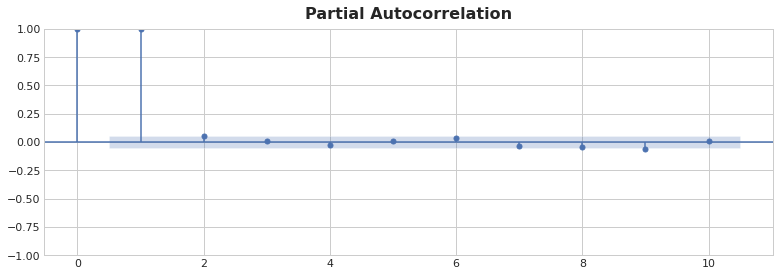

In [62]:
oil = pd.read_csv(oil_path)

oil_fill = oil.fillna(method = 'ffill')
_ = plot_pacf(oil_fill[1:]['dcoilwtico'], lags = 10)

3 lag features for oil should be sufficient.

In [63]:
oil.rename(columns = {"dcoilwtico": "oil_price"}, inplace = True)
# last 7 day avg price
oil["last7d_oil_price"] = oil["oil_price"].rolling(7).mean()
# fill null with previous day oil price
oil = pd.DataFrame({"date": pd.date_range("2013-01-01", "2017-08-31").astype(str)}).merge(oil, on = "date", how = "left")
oil.fillna(method = "ffill", inplace = True)
# lag price
for lag in range(1, 4):
    oil[f"oil_price_lag{lag}"] = oil["oil_price"].shift(lag)
    oil[f"oil_price_lag{lag}"].fillna(oil["oil_price"], inplace = True)
# set date as index
oil["date"] = pd.to_datetime(oil["date"])
oil.set_index(["date"], inplace = True) 

In [64]:
oil.head()

,oil_price,last7d_oil_price,oil_price_lag1,oil_price_lag2,oil_price_lag3
date,,,,,
2013-01-01,NaN,NaN,NaN,NaN,NaN
2013-01-02,93.14,NaN,93.14,93.14,93.14
2013-01-03,92.97,NaN,93.14,92.97,92.97
2013-01-04,93.12,NaN,92.97,93.14,93.12
2013-01-05,93.12,NaN,93.12,92.97,93.14


<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

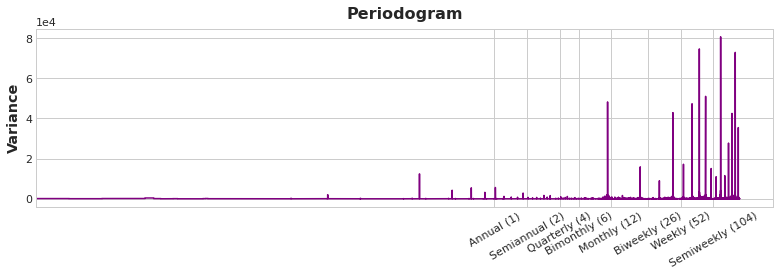

In [65]:
#Let's see if there are any fourier features that would be worth adding...

plot_periodogram(train.sales)

We see many potential seasons present, particularly weekly, semiweekly and biweekly, and potentially monthly as well. 

In [66]:
fourier = CalendarFourier(freq="W", order=4) #"W" for weekly, and order 4 for up to monthly seasonality. 
data = full.reset_index().set_index(["date", "store_nbr", "family"])
y = data["sales"].unstack(["store_nbr", "family"])

dp = DeterministicProcess(
    index= y.index,
    order=1, #Linear
    seasonal=False,
    constant=False,
    additional_terms = [fourier],
    drop = True
)

X = dp.in_sample()
print(X.shape)
      
for i in range(1,4):
    X.rename(columns = {f'sin({i},freq=W-SUN)': f'sin{i}'}, inplace = True)
    X.rename(columns = {f'cos({i},freq=W-SUN)': f'cos{i}'}, inplace = True)

(1700, 7)


In [67]:
X.head()

,trend,sin1,cos1,sin2,cos2,sin3,cos3
date,,,,,,,
2013-01-01,1.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969
2013-01-02,2.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490
2013-01-03,3.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
2013-01-04,4.0,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521
2013-01-05,5.0,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490


In [68]:
#Merge all datasets

merged = full.merge(holidays, left_index = True, right_index = True, how = "left")
merged = merged.merge(oil, left_index = True, right_index = True, how = "left")
merged = merged.merge(X, left_index = True, right_index = True, how = "left")
merged["transferred"].fillna(False, inplace = True)

In [69]:
merged.head()

,id,store_nbr,family,sales,onpromotion,sales_lag1,sales_lag2,sales_lag3,sales_lag4,sales_lag5,...,oil_price_lag1,oil_price_lag2,oil_price_lag3,trend,sin1,cos1,sin2,cos2,sin3,cos3
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,0.781831,0.62349,0.974928,-0.222521,0.433884,-0.900969
2013-01-01,1,1,BABY CARE,0.0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,0.781831,0.62349,0.974928,-0.222521,0.433884,-0.900969
2013-01-01,2,1,BEAUTY,0.0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,0.781831,0.62349,0.974928,-0.222521,0.433884,-0.900969
2013-01-01,3,1,BEVERAGES,0.0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,0.781831,0.62349,0.974928,-0.222521,0.433884,-0.900969
2013-01-01,4,1,BOOKS,0.0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,0.781831,0.62349,0.974928,-0.222521,0.433884,-0.900969


In [70]:
#Finally, we'll add a feature showing whether or not it is as workday...

merged["is_workday"] = 1
merged.loc[merged["dayofweek"].isin(["Saturday", "Sunday"]), "is_workday"] = 0

merged.loc[merged["holiday_type"] == "Bridge", "is_workday"] = 0
merged.loc[merged["holiday_type"] == "Work Day", "is_workday"] = 1
merged.loc[merged["holiday_type"] == "Transfer", "is_workday"] = 0
merged.loc[(merged["holiday_type"] == "Holiday") & (merged["transferred"] == False), "is_workday"] = 0
merged.loc[(merged["holiday_type"] == "Holiday") & (merged["transferred"] == True ), "is_workday"] = 1
merged.drop(columns = ["transferred"], inplace = True)

merged = pd.get_dummies(merged, columns = ["holiday_type", "dayofweek"])

In [71]:
#Let's encode the family column: 

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder() 

merged["family"] = encoder.fit_transform(merged["family"])

In [72]:
merged.head()

,id,store_nbr,family,sales,onpromotion,sales_lag1,sales_lag2,sales_lag3,sales_lag4,sales_lag5,...,holiday_type_Holiday,holiday_type_Transfer,holiday_type_Work Day,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0,1,0,0.0,0,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,1,0,0,0,0,0
2013-01-01,1,1,1,0.0,0,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,1,0,0,0,0,0
2013-01-01,2,1,2,0.0,0,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,1,0,0,0,0,0
2013-01-01,3,1,3,0.0,0,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,1,0,0,0,0,0
2013-01-01,4,1,4,0.0,0,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,1,0,0,0,0,0


In [73]:
merged.columns

Index(['id', 'store_nbr', 'family', 'sales', 'onpromotion', 'sales_lag1',
       'sales_lag2', 'sales_lag3', 'sales_lag4', 'sales_lag5', 'sales_lag6',
       'sales_lag7', 'sales_lag8', 'sales_lag9', 'sales_lag10', 'year',
       'month', 'week', 'day', 'dayofyear', 'oil_price', 'last7d_oil_price',
       'oil_price_lag1', 'oil_price_lag2', 'oil_price_lag3', 'trend', 'sin1',
       'cos1', 'sin2', 'cos2', 'sin3', 'cos3', 'is_workday',
       'holiday_type_Additional', 'holiday_type_Bridge', 'holiday_type_Event',
       'holiday_type_Holiday', 'holiday_type_Transfer',
       'holiday_type_Work Day', 'dayofweek_0', 'dayofweek_1', 'dayofweek_2',
       'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6'],
      dtype='object')

Now let's finally define and train our model. We're going to first use a linear regression model to learn the trend of the data. Therefore, we need to separate off the trend data from the rest of the training data.

In [74]:
#Split dates into training, validation and test:
train_date = ['2013-01-01', '2017-07-31']
valid_date = ['2017-08-01', '2017-08-15'] 
test_date = ['2017-08-16', '2017-08-31']

#Split off trend data:
merged_1 = pd.DataFrame(merged["trend"])
merged_2 = merged.drop("trend", axis=1)

#Split the data accordingly:
X_train_1 = merged_1[train_date[0]:train_date[1]]
X_train_2 = merged_2[train_date[0]:train_date[1]]

X_valid_1 = merged_1[valid_date[0]:valid_date[1]]
X_valid_2 = merged_2[valid_date[0]:valid_date[1]]

X_test = merged[test_date[0]:test_date[1]]
X_test = X_test.drop("sales", axis=1)

y_train = X_train_2.pop("sales")
y_valid = X_valid_2.pop("sales")

In [75]:
"""#Define the target y for the training data:
train_df = pd.read_csv(train_path)
#test = pd.read_csv(test_path)

y = train_df[['store_nbr', 'family', 'date', 'sales']].set_index(['store_nbr', 'family', 'date']).sort_index().unstack(['store_nbr', 'family'])
y_train = y[train_date[0]:train_date[1]]
y_valid = y[valid_date[0]:valid_date[1]]"""

"#Define the target y for the training data:\ntrain_df = pd.read_csv(train_path)\n#test = pd.read_csv(test_path)\n\ny = train_df[['store_nbr', 'family', 'date', 'sales']].set_index(['store_nbr', 'family', 'date']).sort_index().unstack(['store_nbr', 'family'])\ny_train = y[train_date[0]:train_date[1]]\ny_valid = y[valid_date[0]:valid_date[1]]"

In [76]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error


In [77]:
model_1 = LinearRegression()
model_1.fit(X_train_1, y_train)

LinearRegression()

In [78]:
y_pred_1 = model_1.predict(X_train_1) #Need this for the second model, since we fit to the residuals.
y_pred_valid_1 = model_1.predict(X_valid_1) #Will add this to the predictions from the second model to get overall predictions.

In [79]:
y_train - y_pred_1 #See what we have so far

date
2013-01-01   -193.230753
2013-01-01   -193.230753
2013-01-01   -193.230753
2013-01-01   -193.230753
2013-01-01   -193.230753
                 ...    
2017-07-31    -49.877803
2017-07-31   -458.450803
2017-07-31    997.161197
2017-07-31   -464.390803
2017-07-31   -508.390803
Name: sales, Length: 2974158, dtype: float64

In [80]:
mean_absolute_error(y_valid, y_pred_valid_1) #Look at error so far

679.0541594327759

In [81]:
model_2 = XGBRegressor(n_estimators=20)
model_2.fit(X_train_2, y_train-y_pred_1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=20, n_jobs=2,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [82]:
y_pred_valid_2 = model_2.predict(X_valid_2)

In [83]:
mean_absolute_error(y_valid, y_pred_valid_1+y_pred_valid_2) #Total validation error

85.03882170723473

In [84]:
#Make final predictions:

preds = []

y_pred = model_1.predict(pd.DataFrame(X_test["trend"]))

y_pred += model_2.predict(X_test.drop("trend", axis=1))
    
preds.append(y_pred)

In [85]:
#Create the submission data frame: 

preds_df = pd.DataFrame({
    "id": X_test["id"],
    "sales": preds[0]
})

preds_df = preds_df.reset_index().drop("date", axis=1)

In [86]:
preds_df

,id,sales
0,3000888,23.644019
1,3000889,23.644019
2,3000890,23.644019
3,3000891,1833.889503
4,3000892,23.644019
...,...,...
28507,3029395,1124.304062
28508,3029396,1124.304062
28509,3029397,1124.304062
28510,3029398,1124.304062


In [87]:
preds_df.to_csv("submission.csv", index=False)